In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

In [2]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset, Dataset

In [4]:
# Load the full IMDb dataset
data = load_dataset("imdb")

# Subset the training data to 10,000 rows
train_data = data["train"].shuffle(seed=42).select(range(10000))

# Optional: Subset the test data (e.g., reduce to 5,000 rows)
test_data = data["test"].shuffle(seed=42).select(range(5000))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
data_dict = {}
data_dict['train'] = train_data.to_pandas()
data_dict['test'] = test_data.to_pandas()

In [6]:
data_dict['train']

,text,label
0,There is no relation at all between Fortier an...,1
1,This movie is a great. The plot is very true t...,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0
3,In the process of trying to establish the audi...,1
4,"Yeh, I know -- you're quivering with excitemen...",0
...,...,...
9995,I guess this goes to prove that Joe Don Baker ...,0
9996,A very good adaptation of the novel by amrita ...,1
9997,If there's one thing that annoys me most in se...,0
9998,First of all my heartfelt commiserations to an...,0


In [7]:
data_dict['train']['label'].value_counts()

,count
label,
0,5004
1,4996


In [8]:
type(data_dict['train'])

pandas.core.frame.DataFrame

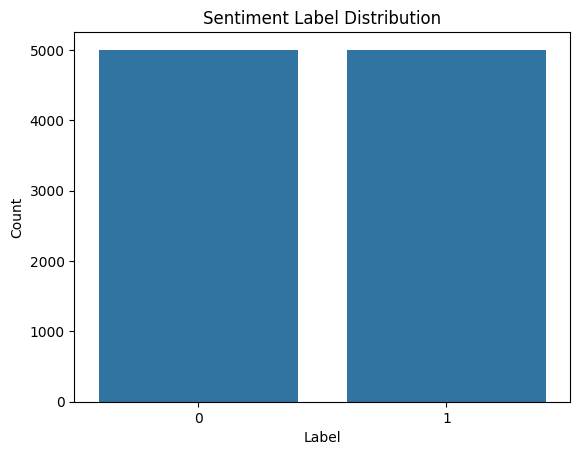

In [9]:
# Ensure label is treated as a category
data_dict['train']['label'] = data_dict['train']['label'].astype('category')

# Plot with explicit order
sns.countplot(data=data_dict['train'], x='label', order=[0, 1])
plt.title("Sentiment Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


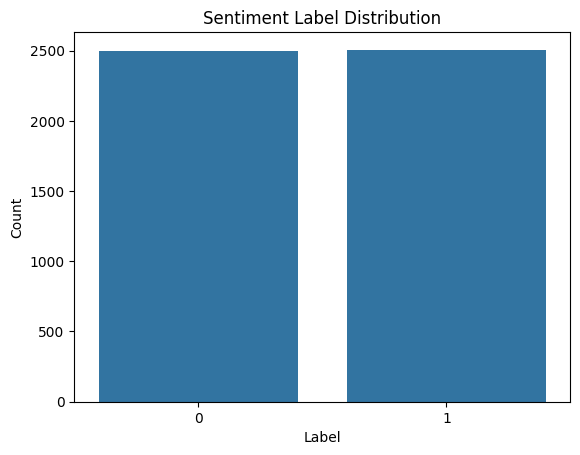

In [10]:
# Ensure label is treated as a category
data_dict['test']['label'] = data_dict['test']['label'].astype('category')

# Plot with explicit order
sns.countplot(data=data_dict['test'], x='label', order=[0, 1])
plt.title("Sentiment Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [11]:
# Check sample reviews
print("Sample Positive Review:\n", data_dict['train'][data_dict['train']['label'] == 1].iloc[0]['text'])
print("Sample Negative Review:\n", data_dict['train'][data_dict['train']['label'] == 0].iloc[0]['text'])

Sample Positive Review:
 There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
Sample Negative Review:
 George P. Cosmatos' "Rambo: First Blood Part II" is pure wish-fulfillment. The United States clearly didn't win the war in Vietnam. They caused damage to this country beyond the imaginable an

In [12]:
# Check sample reviews
print("Sample Positive Review:\n", data_dict['test'][data_dict['test']['label'] == 1].iloc[0]['text'])
print("Sample Negative Review:\n", data_dict['test'][data_dict['test']['label'] == 0].iloc[0]['text'])

Sample Positive Review:
 <br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, however, I realized that this story was about A Thousand Other Things besides just Acres. I started crying and couldn't stop until long after the movie ended. Thank you Jane, Laura and Jocelyn, for bringing us such a wonderfully subtle and compassionate movie! Thank you cast, for being involved and portraying the characters with such depth and gentleness!<br /><br />I recognized the Angry sister; the Runaway sister and the sister in Denial. I recognized the Abusive Husband and why he was there and then the Father, oh oh the Father... all superbly played. I also recognized myself and this movie was an eye-opener, a relief, a chance to face my OWN truth and finally doing something about it. I truly hope A Thousand Acres has had the same effect on some others out

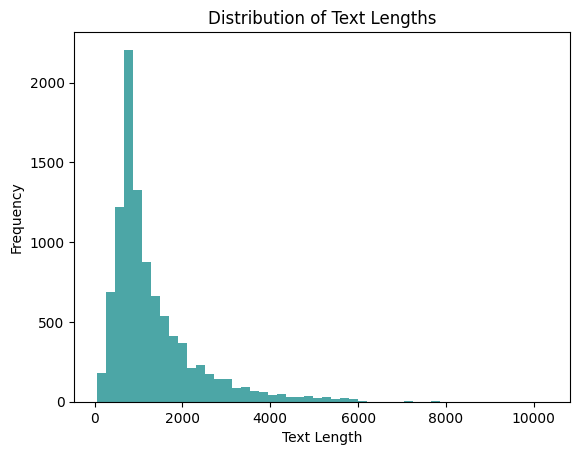

In [13]:
# Text Length Distribution - Train
data_dict['train']['text_length'] = data_dict['train']['text'].apply(len)
plt.hist(data_dict['train']['text_length'], bins=50, color='teal', alpha=0.7)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

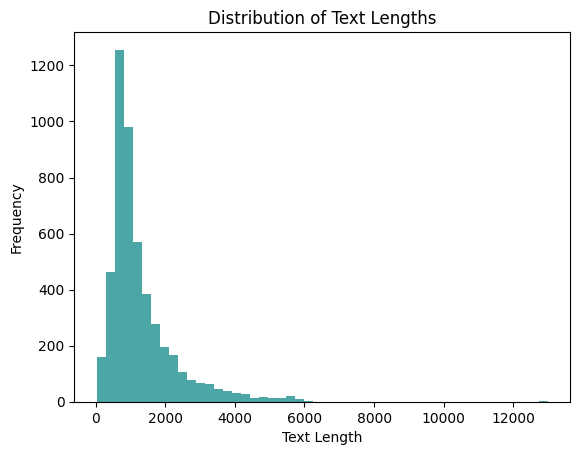

In [14]:
# Text Length Distribution - Test
data_dict['test']['text_length'] = data_dict['test']['text'].apply(len)
plt.hist(data_dict['test']['text_length'], bins=50, color='teal', alpha=0.7)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [15]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [16]:
import evaluate

In [17]:
## bert-base-uncased

In [18]:
# Tokenize the text data using the tokenizer from the BERT model
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=512)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Use BERT tokenizer
tokenized_train = Dataset.from_pandas(data_dict["train"]).map(tokenize, batched=True)
tokenized_test = Dataset.from_pandas(data_dict["test"]).map(tokenize, batched=True)

# Convert dataset to PyTorch tensor format
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Step 3: Load the BERT Model
# Load the pre-trained BERT model with classification head (for binary sentiment analysis)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
training_args = TrainingArguments(
    output_dir="./results",              # Directory to save the model and results
    evaluation_strategy="epoch",         # Evaluate after each epoch
    logging_dir="./logs",                # Directory for logging
    num_train_epochs=3,                  # Number of training epochs
    per_device_train_batch_size=4,       # Batch size per device during training
    per_device_eval_batch_size=16,       # Batch size for evaluation
    gradient_accumulation_steps=2,       # Simulate a larger batch size by accumulating gradients
    save_total_limit=1,                  # Keep only the last checkpoint
    load_best_model_at_end=True,         # Automatically load the best model at the end of training
    metric_for_best_model="eval_accuracy",    # Metric to determine the best model
    save_strategy="epoch",               # Save checkpoints at the end of each epoch
    fp16=True,                           # Enable mixed precision for faster training (requires compatible GPU)
    logging_steps=50,                    # Log training progress every 50 steps
    report_to="none",                    # Disable integration with external logging tools like WandB
    learning_rate=5e-5,                  # Learning rate for the optimizer
    weight_decay=0.01                    # Weight decay to prevent overfitting
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
import evaluate
import torch

# Load a predefined metric (e.g., accuracy)
metric = evaluate.load("accuracy")
def compute_metrics(p):
    predictions, labels = p
    predictions = torch.tensor(predictions)  # Convert predictions to torch tensor if it's a numpy array
    preds = torch.argmax(predictions, dim=1)  # Get the predicted labels (use dim=1)
    return metric.compute(predictions=preds, references=labels)

In [21]:
# Initialize the Trainer
# Use the Trainer API for training and evaluation
trainer_bertbased = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-21-b25fb3af514b>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bertbased = Trainer(


In [22]:
# Train and Evaluate the Model
trainer_bertbased.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.606100,0.322953,0.914000
2,0.469700,0.351856,0.922800
3,0.101400,0.437942,0.925400


TrainOutput(global_step=3750, training_loss=0.44712463982899986, metrics={'train_runtime': 1122.5041, 'train_samples_per_second': 26.726, 'train_steps_per_second': 3.341, 'total_flos': 7893331660800000.0, 'train_loss': 0.44712463982899986, 'epoch': 3.0})

In [28]:
# evaluate the model after training
eval_results_bert = trainer_bertbased.evaluate()
print("Evaluation Results:", eval_results_bert)

Evaluation Results: {'eval_loss': 0.43794217705726624, 'eval_accuracy': 0.9254, 'eval_runtime': 36.7199, 'eval_samples_per_second': 136.166, 'eval_steps_per_second': 8.524, 'epoch': 3.0}


In [29]:
# Run predictions
predictions_bert = trainer_bertbased.predict(tokenized_test)

# Extract predicted labels
preds = torch.argmax(torch.tensor(predictions_bert.predictions), dim=1)


In [26]:
# Add predictions to the original test DataFrame
test_with_predictions = data_dict["test"].copy()
test_with_predictions["bert-base_predicted_label"] = preds.tolist()

# View the results
print(test_with_predictions.head())


                                                text label  text_length  \
0  <br /><br />When I unsuspectedly rented A Thou...     1         1792   
1  This is the latest entry in the long series of...     1          918   
2  This movie was so frustrating. Everything seem...     0          665   
3  I was truly and wonderfully surprised at "O' B...     1          583   
4  This movie spends most of its time preaching t...     0          482   

   bert-base_predicted_label  
0                          1  
1                          1  
2                          0  
3                          1  
4                          0  


In [56]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F  # For applying softmax

# Step 1: Load the fine-tuned model and tokenizer
# Ensure the "./results" directory contains your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("./results/checkpoint-3750")

# Step 2: Define a prediction function
def predict_new_data(sentence):
    """
    Predict sentiment for a given sentence, including probabilities.
    Args:
    - sentence (str): The input sentence to classify.

    Returns:
    - str: The predicted sentiment label ("Positive" or "Negative").
    - dict: The probabilities for each class.
    """
    try:
        # Tokenize the input sentence
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
        # Perform inference
        outputs = model(**inputs)
        # Get the logits
        logits = outputs.logits
        # Apply softmax to calculate probabilities
        probabilities = F.softmax(logits, dim=1).squeeze().tolist()
        # Get the predicted class
        predicted_class = torch.argmax(logits, dim=1).item()
        # Map class index to label
        label_map = {0: "Negative", 1: "Positive"}
        # Format probabilities with labels
        prob_dict = {label_map[i]: prob for i, prob in enumerate(probabilities)}
        return label_map[predicted_class], prob_dict
    except Exception as e:
        return f"Error during prediction: {e}"

# Step 3: Allow user to input sentences for prediction
print("Enter sentences to predict their sentiment (type 'exit' to stop):")
while True:
    user_input = input("Enter a sentence: ")
    if user_input.lower() == "exit":
        print("Exiting sentiment prediction.")
        break
    try:
        prediction, probabilities = predict_new_data(user_input)
        print(f"Predicted Sentiment: {prediction}")
        print(f"Probabilities: {probabilities}\n")
    except Exception as e:
        print(f"Error occurred: {e}")


Enter sentences to predict their sentiment (type 'exit' to stop):
Enter a sentence: Space Invaders: The Reckoning tries to deliver a high-octane space adventure but crashes under the weight of its own clichés. The dialogue is painfully cheesy, and the characters are so one-dimensional they feel like they were written by an AI on autopilot. The CGI-heavy battles start off promising but quickly become repetitive and chaotic, with no sense of stakes. While there are a few moments of unintentional humor, the overall experience feels like a forgettable knockoff of far better sci-fi epics. Not even the most hardcore space enthusiasts will find much to enjoy here.
Predicted Sentiment: Negative
Probabilities: {'Negative': 0.9997492432594299, 'Positive': 0.00025074961013160646}

Enter a sentence: The Grand Adventure is a rollercoaster ride of adrenaline, breathtaking visuals, and heart-pounding action. The film’s protagonist embarks on a daring quest that keeps you glued to your seat from start

In [ ]:
## roberta-basea

In [30]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# Correct the tokenize function by explicitly passing the tokenizer
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=512)

# Use lambda to pass the tokenizer explicitly when calling map
tokenized_train = Dataset.from_pandas(data_dict["train"]).map(lambda x: tokenize(x), batched=True)
tokenized_test = Dataset.from_pandas(data_dict["test"]).map(lambda x: tokenize(x), batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [31]:
# Convert dataset to PyTorch tensor format
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
# Load the RoBERTa Model
# Load the pre-trained RoBERTa model with classification head (for binary sentiment analysis)
model1 = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
training_args = TrainingArguments(
    output_dir="./RobertResult",              # Directory to save the model and results
    evaluation_strategy="epoch",         # Evaluate after each epoch
    logging_dir="./logs",                # Directory for logging
    num_train_epochs=3,                  # Number of training epochs
    per_device_train_batch_size=4,       # Batch size per device during training
    per_device_eval_batch_size=16,       # Batch size for evaluation
    gradient_accumulation_steps=2,       # Simulate a larger batch size by accumulating gradients
    save_total_limit=1,                  # Keep only the last checkpoint
    load_best_model_at_end=True,         # Automatically load the best model at the end of training
    metric_for_best_model="eval_accuracy",    # Metric to determine the best model
    save_strategy="epoch",               # Save checkpoints at the end of each epoch
    fp16=True,                           # Enable mixed precision for faster training (requires compatible GPU)
    logging_steps=50,                    # Log training progress every 50 steps
    report_to="none",                    # Disable integration with external logging tools like WandB
    learning_rate=5e-5,                  # Learning rate for the optimizer
    weight_decay=0.01                    # Weight decay to prevent overfitting
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
# Initialize the Trainer
# Use the Trainer API for training and evaluation
trainer_robertabase = Trainer(
    model=model1,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-33-3cf40eb16d41>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_robertabase = Trainer(


In [34]:
# Train and Evaluate the Model
trainer_robertabase.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.661500,0.286600,0.916800
2,0.523200,0.362303,0.925800
3,0.408500,0.334948,0.931200


TrainOutput(global_step=3750, training_loss=0.6147301717122395, metrics={'train_runtime': 1277.5013, 'train_samples_per_second': 23.483, 'train_steps_per_second': 2.935, 'total_flos': 7893331660800000.0, 'train_loss': 0.6147301717122395, 'epoch': 3.0})

In [35]:
# evaluate the model after training
eval_results_roberta = trainer_robertabase.evaluate()
print("Evaluation Results:", eval_results_roberta)

Evaluation Results: {'eval_loss': 0.33494794368743896, 'eval_accuracy': 0.9312, 'eval_runtime': 35.6063, 'eval_samples_per_second': 140.424, 'eval_steps_per_second': 8.791, 'epoch': 3.0}


In [36]:
# Run predictions
predictions_roberta = trainer_robertabase.predict(tokenized_test)

# Extract predicted labels
preds = torch.argmax(torch.tensor(predictions_roberta.predictions), dim=1)


In [37]:
test_with_predictions["roberta-base_predicted_label"] = preds.tolist()

# View the results
print(test_with_predictions.head())

                                                text label  text_length  \
0  <br /><br />When I unsuspectedly rented A Thou...     1         1792   
1  This is the latest entry in the long series of...     1          918   
2  This movie was so frustrating. Everything seem...     0          665   
3  I was truly and wonderfully surprised at "O' B...     1          583   
4  This movie spends most of its time preaching t...     0          482   

   bert-base_predicted_label  roberta-base_predicted_label  
0                          1                             1  
1                          1                             1  
2                          0                             0  
3                          1                             1  
4                          0                             0  


In [53]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F  # For applying softmax

# Step 1: Load the fine-tuned model and tokenizer
# Ensure the "./results" directory contains your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("./RobertResult/checkpoint-3750")

# Step 2: Define a prediction function
def predict_new_data(sentence):
    """
    Predict sentiment for a given sentence, including probabilities.
    Args:
    - sentence (str): The input sentence to classify.

    Returns:
    - str: The predicted sentiment label ("Positive" or "Negative").
    - dict: The probabilities for each class.
    """
    try:
        # Tokenize the input sentence
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
        # Perform inference
        outputs = model(**inputs)
        # Get the logits
        logits = outputs.logits
        # Apply softmax to calculate probabilities
        probabilities = F.softmax(logits, dim=1).squeeze().tolist()
        # Get the predicted class
        predicted_class = torch.argmax(logits, dim=1).item()
        # Map class index to label
        label_map = {0: "Negative", 1: "Positive"}
        # Format probabilities with labels
        prob_dict = {label_map[i]: prob for i, prob in enumerate(probabilities)}
        return label_map[predicted_class], prob_dict
    except Exception as e:
        return f"Error during prediction: {e}"

# Step 3: Allow user to input sentences for prediction
print("Enter sentences to predict their sentiment (type 'exit' to stop):")
while True:
    user_input = input("Enter a sentence: ")
    if user_input.lower() == "exit":
        print("Exiting sentiment prediction.")
        break
    try:
        prediction, probabilities = predict_new_data(user_input)
        print(f"Predicted Sentiment: {prediction}")
        print(f"Probabilities: {probabilities}\n")
    except Exception as e:
        print(f"Error occurred: {e}")


Enter sentences to predict their sentiment (type 'exit' to stop):
Enter a sentence: Space Invaders: The Reckoning tries to deliver a high-octane space adventure but crashes under the weight of its own clichés. The dialogue is painfully cheesy, and the characters are so one-dimensional they feel like they were written by an AI on autopilot. The CGI-heavy battles start off promising but quickly become repetitive and chaotic, with no sense of stakes. While there are a few moments of unintentional humor, the overall experience feels like a forgettable knockoff of far better sci-fi epics. Not even the most hardcore space enthusiasts will find much to enjoy here.
Predicted Sentiment: Negative
Probabilities: {'Negative': 0.9976898431777954, 'Positive': 0.002310137962922454}

Enter a sentence: Love in the City charms with its witty dialogue and relatable characters. The chemistry between the leads is undeniable, and their banter feels fresh and natural. While the plot treads familiar territory

In [54]:
# distilbert base

In [39]:
metric = evaluate.load("accuracy")

def compute_metrics(p):
    predictions, labels = p
    # Convert predictions to torch tensor if it's a numpy array
    predictions = torch.tensor(predictions) if not isinstance(predictions, torch.Tensor) else predictions
    # Get the predicted labels
    preds = torch.argmax(predictions, dim=1)
    # Return the metric with the correct key
    return {"eval_accuracy": metric.compute(predictions=preds, references=labels)["accuracy"]}


In [40]:
# Step 2: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./distilbertresults",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",  # Use the correct metric name
    save_strategy="epoch",
    fp16=True,
    logging_steps=50,
    report_to="none",
    learning_rate=5e-5,
    weight_decay=0.01,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [41]:
# Tokenize the text data using the tokenizer from the BERT model
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=512)
# Step 3: Initialize Trainer and Model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
tokenized_train = Dataset.from_pandas(data_dict["train"]).map(tokenize, batched=True)
tokenized_test = Dataset.from_pandas(data_dict["test"]).map(tokenize, batched=True)
# Assuming you already have tokenized datasets: `tokenized_train` and `tokenized_test`
trainer_distilbert = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

<ipython-input-41-a1754f6e2867>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distilbert = Trainer(


In [42]:
# Step 4: Train and Evaluate
trainer_distilbert.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.637600,0.301415,0.910000
2,0.492800,0.397720,0.912400
3,0.226200,0.462723,0.919000


TrainOutput(global_step=3750, training_loss=0.45744895890553794, metrics={'train_runtime': 626.539, 'train_samples_per_second': 47.882, 'train_steps_per_second': 5.985, 'total_flos': 3974021959680000.0, 'train_loss': 0.45744895890553794, 'epoch': 3.0})

In [43]:
# evaluate the model after training
eval_results_distilbert = trainer_distilbert.evaluate()
print("Evaluation Results:", eval_results_distilbert)

Evaluation Results: {'eval_accuracy': 0.919, 'eval_loss': 0.4627227187156677, 'eval_runtime': 20.4446, 'eval_samples_per_second': 244.563, 'eval_steps_per_second': 15.31, 'epoch': 3.0}


In [44]:
# Run predictions
distilbert_predictions = trainer_distilbert.predict(tokenized_test)

# Extract predicted labels
preds = torch.argmax(torch.tensor(distilbert_predictions.predictions), dim=1)


In [45]:
test_with_predictions["distilbert_predicted_label"] = preds.tolist()

# View the results
print(test_with_predictions.head())

                                                text label  text_length  \
0  <br /><br />When I unsuspectedly rented A Thou...     1         1792   
1  This is the latest entry in the long series of...     1          918   
2  This movie was so frustrating. Everything seem...     0          665   
3  I was truly and wonderfully surprised at "O' B...     1          583   
4  This movie spends most of its time preaching t...     0          482   

   bert-base_predicted_label  roberta-base_predicted_label  \
0                          1                             1   
1                          1                             1   
2                          0                             0   
3                          1                             1   
4                          0                             0   

   distilbert_predicted_label  
0                           1  
1                           1  
2                           0  
3                           1  
4               

In [57]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F  # For softmax

# Step 1: Load the fine-tuned model and tokenizer
model_path = "./distilbertresults/checkpoint-3750"  # Ensure this path is correct
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Step 2: Define a prediction function
def predict_new_data(sentence):
    """
    Predict sentiment for a given sentence and return probabilities.
    """
    try:
        # Tokenize the input sentence
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
        # Perform inference
        outputs = model(**inputs)
        logits = outputs.logits
        # Apply softmax to compute probabilities
        probabilities = F.softmax(logits, dim=1).squeeze().tolist()
        # Get the predicted class
        predicted_class = torch.argmax(logits, dim=1).item()
        # Map class index to label
        label_map = {0: "Negative", 1: "Positive"}
        # Format probabilities with labels
        prob_dict = {label_map[i]: prob for i, prob in enumerate(probabilities)}
        return label_map[predicted_class], prob_dict
    except Exception as e:
        print(f"Error during prediction: {e}")
        return "Error", {}

# Step 3: Allow user to input sentences for prediction
print("Enter sentences to predict their sentiment (type 'exit' to stop):")
while True:
    user_input = input("Enter a sentence: ")
    if user_input.lower() == "exit":
        print("Exiting sentiment prediction.")
        break
    predicted_label, probabilities = predict_new_data(user_input)
    print(f"Predicted Sentiment: {predicted_label}")
    print(f"Probabilities: {probabilities}\n")


Enter sentences to predict their sentiment (type 'exit' to stop):
Enter a sentence: Space Invaders: The Reckoning tries to deliver a high-octane space adventure but crashes under the weight of its own clichés. The dialogue is painfully cheesy, and the characters are so one-dimensional they feel like they were written by an AI on autopilot. The CGI-heavy battles start off promising but quickly become repetitive and chaotic, with no sense of stakes. While there are a few moments of unintentional humor, the overall experience feels like a forgettable knockoff of far better sci-fi epics. Not even the most hardcore space enthusiasts will find much to enjoy here.
Predicted Sentiment: Negative
Probabilities: {'Negative': 0.9996140599250793, 'Positive': 0.0003860143187921494}

Enter a sentence: A masterclass in suspense, Beyond the Shadows grips you with its chilling atmosphere and relentless tension. The haunting score and clever use of lighting create a sense of dread that lingers long after

In [58]:
test_with_predictions

,text,label,text_length,bert-base_predicted_label,roberta-base_predicted_label,distilbert_predicted_label
0,<br /><br />When I unsuspectedly rented A Thou...,1,1792,1,1,1
1,This is the latest entry in the long series of...,1,918,1,1,1
2,This movie was so frustrating. Everything seem...,0,665,0,0,0
3,"I was truly and wonderfully surprised at ""O' B...",1,583,1,1,1
4,This movie spends most of its time preaching t...,0,482,0,0,0
...,...,...,...,...,...,...
4995,This was a pleasant musical about the creation...,1,731,1,1,1
4996,"OK, I saw this film through Mystery Science Th...",0,1859,0,0,0
4997,It's painfully clear that all effort in this f...,0,1512,0,0,0
4998,The Vietnam War era is certainly far before my...,1,1373,1,1,1


In [60]:
import pandas as pd

# Assuming eval_results_bert, eval_results_roberta, eval_results_distilbert are the evaluation results for each model
eval_results_bert = trainer_bertbased.evaluate()
eval_results_roberta = trainer_robertabase.evaluate()
eval_results_distilbert = trainer_distilbert.evaluate()

# Swap eval_loss and eval_accuracy for DistilBERT
distilbert_corrected = eval_results_distilbert.copy()
distilbert_corrected["eval_loss"], distilbert_corrected["eval_accuracy"] = (
    eval_results_distilbert["eval_accuracy"],
    eval_results_distilbert["eval_loss"],
)

# Create a dictionary with evaluation results
results = {
    "Metric": list(eval_results_bert.keys()),  # Extract metric names
    "BERT-Base": list(eval_results_bert.values()),  # BERT evaluation values
    "RoBERTa-Base": list(eval_results_roberta.values()),  # RoBERTa evaluation values
    "DistilBERT-Base": list(distilbert_corrected.values()),  # Corrected DistilBERT values
}

# Convert to a pandas DataFrame for display
results_df = pd.DataFrame(results)

# Print the table
print("Model Evaluation Results:")
print(results_df)


Model Evaluation Results:
                    Metric   BERT-Base  RoBERTa-Base  DistilBERT-Base
0                eval_loss    0.437942      0.334948         0.462723
1            eval_accuracy    0.925400      0.931200         0.919000
2             eval_runtime   39.175300     35.032100        20.977900
3  eval_samples_per_second  127.631000    142.726000       238.346000
4    eval_steps_per_second    7.990000      8.935000        14.920000
5                    epoch    3.000000      3.000000         3.000000


In [ ]:
#gpt2 model

In [59]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
import torch
import evaluate

# Step 1: Load and Prepare Dataset
# Load the IMDB dataset from Hugging Face
dataset = load_dataset("imdb")

# Split into train and test datasets
train_data = dataset["train"].shuffle(seed=42).select(range(5000))  # Subset for faster training
test_data = dataset["test"].shuffle(seed=42).select(range(1000))

# Step 2: Tokenize the Dataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a padding token by default

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=512)

train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

# Convert dataset to PyTorch tensors
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Step 3: Load the GPT-2 Model
# Add a classification head to GPT-2
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id  # Set the padding token ID

# Step 4: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./gpt2_results",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    logging_steps=50,
    report_to="none",
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Step 5: Define Metrics
metric = evaluate.load("accuracy")

def compute_metrics(p):
    predictions, labels = p
    preds = torch.argmax(torch.tensor(predictions), dim=1)
    return metric.compute(predictions=preds, references=labels)

# Step 6: Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Step 7: Train and Evaluate the Model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)




tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-59-e377822ea72c>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.428900,0.502373,0.873000
2,0.163700,0.433024,0.906000


Evaluation Results: {'eval_loss': 0.43302416801452637, 'eval_accuracy': 0.906, 'eval_runtime': 12.5428, 'eval_samples_per_second': 79.727, 'eval_steps_per_second': 5.023, 'epoch': 2.0}


In [62]:
import torch

# Step 8: Predict on a Custom Sentence
def predict_sentiment(sentence):
    # Move the model to the same device as the tensors
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize and move inputs to the same device
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Perform inference
    with torch.no_grad():  # No gradient calculation needed during prediction
        outputs = model(**inputs)
    logits = outputs.logits

    # Determine the predicted class
    predicted_class = torch.argmax(logits, dim=1).item()
    return "Positive" if predicted_class == 1 else "Negative"

# Test the model on a custom sentence
test_sentence = "The movie was absolutely fantastic and inspiring!"
prediction = predict_sentiment(test_sentence)
print(f"Sentiment for '{test_sentence}': {prediction}")


Sentiment for 'The movie was absolutely fantastic and inspiring!': Positive
